# Master BigData UCM 2023

## AGRADECIMIENTOS

Este script está basado en el trabajo de Diva Flores, alumna de la clase 2 del máster. Quiero agradecerla aquí el gran trabajo que realizó para localizar los datos de población y su pre-proceso, que no es trivial, como veréis



# Visualización Avanzada
En el presente trabajo se analizarán los datos de COVID-19 que se obtienen a partir de la declaración de los casos a la Red Nacional de Vigilancia Epidemiológica (RENAVE) a través de la plataforma informática vía Web SiViES (Sistema de Vigilancia de España) que gestiona el Centro Nacional de Epidemiología (CNE). Estos datos corresponden al periodo comprendido entre el inicio de la pandemia (enero-2020) hasta el 28 de marzo de 2022.

Para realizar algunos cálculos más específicos utilizaremos datos del INE, específicamente de población por provincia y franja etaria de los últimos tres años (2020, 2021 y 2022) y los datos de polígonos que correspoden a las representaciones gráficas de las provincias de España.

**Para empezar, importamos las librerías que utilizaremos para este análisis.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from datetime import date
from datetime import datetime


### Lectura de datasets
Realizamos la lectura de los datasets de Covid y provincias (previamente descargados) y realizamos unos primeros ajustes a los mismos.

Los archivos se encuentran en el mismo repositorio github del presente notebook.

In [2]:
covid = pd.read_csv(r'casos_hosp_uci_def_sexo_edad_provres.csv')
prv = pd.read_csv(r'provinces_es.csv')
# geo_prv = r'SP_provincias.geojson'


**Realizamos una pre-visualización del contenido**

In [3]:
covid.head()

,provincia_iso,sexo,grupo_edad,fecha,num_casos,num_hosp,num_uci,num_def
0,A,H,0-9,2020-01-01,0,0,0,0
1,A,H,10-19,2020-01-01,0,0,0,0
2,A,H,20-29,2020-01-01,0,0,0,0
3,A,H,30-39,2020-01-01,0,0,0,0
4,A,H,40-49,2020-01-01,0,0,0,0


In [4]:
prv.head()

,code,postal_code,name,phone_code,iso2
0,VI,1,Álava,945,ES
1,AB,2,Albacete,967,ES
2,A,3,Alacant,950,ES
3,AL,4,Almería,920,ES
4,AV,5,Ávila,924,ES


**Empezamos uniendo nuestros datasets de covid y provincias, mediante el código "provincia_iso" (en covid) o "code" en prv**

In [5]:
cov_prv = covid.merge(prv, 
                      how='left', 
                      left_on='provincia_iso', 
                      right_on='code', 
                      suffixes=('_cov', '_prv'))

In [6]:
cov_prv.head()

,provincia_iso,sexo,grupo_edad,fecha,num_casos,num_hosp,num_uci,num_def,code,postal_code,name,phone_code,iso2
0,A,H,0-9,2020-01-01,0,0,0,0,A,3.0,Alacant,950.0,ES
1,A,H,10-19,2020-01-01,0,0,0,0,A,3.0,Alacant,950.0,ES
2,A,H,20-29,2020-01-01,0,0,0,0,A,3.0,Alacant,950.0,ES
3,A,H,30-39,2020-01-01,0,0,0,0,A,3.0,Alacant,950.0,ES
4,A,H,40-49,2020-01-01,0,0,0,0,A,3.0,Alacant,950.0,ES


**Realizamos algunos formateos a los datos, para que nos ayuden en las visualizaciones posteriores, y eliminamos variables que no se van a usar**

In [7]:
cov_prv['periodo'] = cov_prv['fecha'].str.slice(0, 4)
cov_prv['periodo'] = pd.to_numeric(cov_prv['periodo'])
cov_prv['fecha'] = pd.to_datetime(covid['fecha'], 
                                  format = '%Y-%m-%d', 
                                  errors = 'coerce')
cov_prv['semana'] = cov_prv['fecha'].dt.week

cov_prv.drop(['name', 'phone_code', 'iso2'], 
             axis = 'columns', 
             inplace=True)
cov_prv.rename(columns={'grupo_edad': 'franja_etaria'}, 
               inplace=True)
cov_prv.head()

,provincia_iso,sexo,franja_etaria,fecha,num_casos,num_hosp,num_uci,num_def,code,postal_code,periodo,semana
0,A,H,0-9,2020-01-01,0,0,0,0,A,3.0,2020,1
1,A,H,10-19,2020-01-01,0,0,0,0,A,3.0,2020,1
2,A,H,20-29,2020-01-01,0,0,0,0,A,3.0,2020,1
3,A,H,30-39,2020-01-01,0,0,0,0,A,3.0,2020,1
4,A,H,40-49,2020-01-01,0,0,0,0,A,3.0,2020,1


**Realizamos la importación de los datos de población de cada provincia, correspondientes a los años 2020, 2021 y 2022.**

**Luego uniremos las tres fuentes en un único dataset.**

**IMPORTANTE: veréis que se leen directamente los datos, especificando que la coma es el separador decimal, y el punto los miles**

In [8]:
pob_esp2020 = pd.read_csv(r'PoblacionEspana-Provincia_2020.csv',
                          sep=';',
                          encoding='latin-1'
                          ,
                          decimal = ',',
                          thousands = '.'
                         )


In [9]:
pob_esp2020.head()

,Edad Simple,Provincias,Sexo,Periodo,Total
0,0 años,02 Albacete,Hombres,1 de julio de 2020,1475.5
1,0 años,02 Albacete,Mujeres,1 de julio de 2020,1352.5
2,0 años,03 Alicante/Alacant,Hombres,1 de julio de 2020,6962.0
3,0 años,03 Alicante/Alacant,Mujeres,1 de julio de 2020,6641.0
4,0 años,04 Almería,Hombres,1 de julio de 2020,3568.5


In [10]:
pob_esp2020.describe(include = 'all')

,Edad Simple,Provincias,Sexo,Periodo,Total
count,10504,10504,10504,10504,10504.000000
unique,101,52,2,1,NaN
top,0 años,02 Albacete,Hombres,1 de julio de 2020,NaN
freq,104,202,5252,10504,NaN
mean,NaN,NaN,NaN,NaN,4508.347732
std,NaN,NaN,NaN,NaN,6815.777133
min,NaN,NaN,NaN,NaN,0.756743
25%,NaN,NaN,NaN,NaN,1061.426210
50%,NaN,NaN,NaN,NaN,2574.354729
75%,NaN,NaN,NaN,NaN,5043.655903


In [11]:
pob_esp2021 = pd.read_csv(r'PoblacionEspana-Provincia_2021.csv',
                          sep=';',
                          encoding='latin-1'
                          ,
                          decimal = ',',
                          thousands = '.'
                         )


In [12]:
pob_esp2022 = pd.read_csv(r'PoblacionEspana-Provincia_2022.csv',
                          sep=';',
                          encoding='latin-1'
                          ,
                          decimal = ',',
                          thousands = '.'
                         )


In [13]:
pob_esp = pd.concat([pob_esp2020, pob_esp2021, pob_esp2022])
pob_esp.head(3)

,Edad Simple,Provincias,Sexo,Periodo,Total
0,0 años,02 Albacete,Hombres,1 de julio de 2020,1475.5
1,0 años,02 Albacete,Mujeres,1 de julio de 2020,1352.5
2,0 años,03 Alicante/Alacant,Hombres,1 de julio de 2020,6962.0


**A continuación simplemente cambiamos nombres de variables en pob_esp para facilitarnos mezclas o análisis posteriores**

In [14]:
pob_esp.rename(columns={'Edad Simple': 'edad', 
                        'Provincias': 'provincia', 
                        'Sexo':'sexo', 
                        'Periodo':'periodo', 
                        'Total':'total'}, 
               inplace=True)

**A continuación extraemos el código postal de los dos primeros caracteres de la columna "provincia". Los pasamos  numéricos porque es el formato que tenemos en cov_prv**

In [15]:
pob_esp['postal_code'] = pob_esp['provincia'].str.slice(0, 2)
pob_esp['postal_code'] = pd.to_numeric(pob_esp['postal_code'])

**Debemos tener los mismos códigos para hombre y mujer en pob_esp y en cov_prv**

In [16]:
pob_esp.loc[pob_esp['sexo'] == 'Hombres', 'sexo'] = 'H'
pob_esp.loc[pob_esp['sexo'] == 'Mujeres', 'sexo'] = 'M'

**Este es quizás el punto más extraño: Para tener la edad solo con el número -p. ej. 0 años: 0- separamos toda la cadena edad, de tal manera que nos extraerá tantas columnas como palabras separadas encuentra. Encuenra 4 columnas porque la última es "100 años y más".**

**Luego se pasan los números a numeric**

In [17]:
datos = pob_esp['edad'].str.split(expand=True)
datos.columns = ['edad2', 'edad3', 'edad4', 'edad5']
pob_esp = pd.concat([pob_esp, datos], axis=1)
pob_esp.drop(['edad3', 'edad4', 'edad5'], 
             axis = 'columns', 
             inplace=True)
pob_esp['edad2'] = pd.to_numeric(pob_esp['edad2'])
pob_esp.head(3)


,edad,provincia,sexo,periodo,total,postal_code,edad2
0,0 años,02 Albacete,H,1 de julio de 2020,1475.5,2,0
1,0 años,02 Albacete,M,1 de julio de 2020,1352.5,2,0
2,0 años,03 Alicante/Alacant,H,1 de julio de 2020,6962.0,3,0


In [18]:
pob_esp.tail(20)

,edad,provincia,sexo,periodo,total,postal_code,edad2
10484,100 y más años,42 Soria,H,1 de julio de 2022,25.896871,42,100
10485,100 y más años,42 Soria,M,1 de julio de 2022,65.502683,42,100
10486,100 y más años,43 Tarragona,H,1 de julio de 2022,76.528673,43,100
10487,100 y más años,43 Tarragona,M,1 de julio de 2022,223.568433,43,100
10488,100 y más años,44 Teruel,H,1 de julio de 2022,23.689391,44,100
10489,100 y más años,44 Teruel,M,1 de julio de 2022,82.272227,44,100
10490,100 y más años,45 Toledo,H,1 de julio de 2022,55.745870,45,100
10491,100 y más años,45 Toledo,M,1 de julio de 2022,261.526210,45,100
10492,100 y más años,46 Valencia/València,H,1 de julio de 2022,167.463466,46,100
10493,100 y más años,46 Valencia/València,M,1 de julio de 2022,648.014681,46,100


**Definimos los rangos de edad igual que están en cov_prv**

In [19]:
def franja_etaria(edad):
    if edad < 10:
        franja = '0-9'
    elif edad < 20:
        franja = '10-19'
    elif edad < 30:
        franja = '20-29'
    elif edad < 40:
        franja = '30-39'
    elif edad < 50:
        franja = '40-49'
    elif edad < 60:
        franja = '50-59'
    elif edad < 70:
        franja = '60-69'
    elif edad < 80:
        franja = '70-79'
    else:
        franja = '80+'
    return franja

In [20]:
pob_esp['franja_etaria'] = pob_esp['edad2'].apply(franja_etaria)

**Por último dejamos nada más el año en la variable periodo**

In [21]:
separado = pob_esp['periodo'].str.split(' ', expand=True)
pob_esp['periodo']= separado[4]
pob_esp['periodo'] = pd.to_numeric(pob_esp['periodo'])
pob_esp.head(3)

,edad,provincia,sexo,periodo,total,postal_code,edad2,franja_etaria
0,0 años,02 Albacete,H,2020,1475.5,2,0,0-9
1,0 años,02 Albacete,M,2020,1352.5,2,0,0-9
2,0 años,03 Alicante/Alacant,H,2020,6962.0,3,0,0-9


In [22]:
pob_esp.tail(20)

,edad,provincia,sexo,periodo,total,postal_code,edad2,franja_etaria
10484,100 y más años,42 Soria,H,2022,25.896871,42,100,80+
10485,100 y más años,42 Soria,M,2022,65.502683,42,100,80+
10486,100 y más años,43 Tarragona,H,2022,76.528673,43,100,80+
10487,100 y más años,43 Tarragona,M,2022,223.568433,43,100,80+
10488,100 y más años,44 Teruel,H,2022,23.689391,44,100,80+
10489,100 y más años,44 Teruel,M,2022,82.272227,44,100,80+
10490,100 y más años,45 Toledo,H,2022,55.745870,45,100,80+
10491,100 y más años,45 Toledo,M,2022,261.526210,45,100,80+
10492,100 y más años,46 Valencia/València,H,2022,167.463466,46,100,80+
10493,100 y más años,46 Valencia/València,M,2022,648.014681,46,100,80+


**A continuación, agrupamos los datos de poblacion por año y provincia, para cruzarlo con nuestro dataset de casos de Covid.**

In [23]:
poblacion00 = pob_esp.groupby(['periodo', 
                             'provincia', 
                             'postal_code',
                             'franja_etaria'
                            ]).agg({'total':'sum'}).reset_index()
poblacion00.head()

,periodo,provincia,postal_code,franja_etaria,total
0,2020,01 Araba/Álava,1,0-9,31709.299340
1,2020,01 Araba/Álava,1,10-19,32961.976182
2,2020,01 Araba/Álava,1,20-29,29243.296939
3,2020,01 Araba/Álava,1,30-39,38658.627289
4,2020,01 Araba/Álava,1,40-49,54453.120853


In [24]:
poblacion = poblacion00.merge(prv, 
                        how='left', 
                        left_on='postal_code', 
                        right_on='postal_code',
                        suffixes=('_cov', '_prv'))

In [25]:
poblacion.head()

,periodo,provincia,postal_code,franja_etaria,total,code,name,phone_code,iso2
0,2020,01 Araba/Álava,1,0-9,31709.299340,VI,Álava,945,ES
1,2020,01 Araba/Álava,1,10-19,32961.976182,VI,Álava,945,ES
2,2020,01 Araba/Álava,1,20-29,29243.296939,VI,Álava,945,ES
3,2020,01 Araba/Álava,1,30-39,38658.627289,VI,Álava,945,ES
4,2020,01 Araba/Álava,1,40-49,54453.120853,VI,Álava,945,ES


### Incidencia Acumulada a 14 días por cada 100.000 habitantes
Calculamos la IA a 14 días por cada cien mil habitantes.

In [26]:
sum_cov = cov_prv.groupby(['fecha', 'periodo']).agg({'num_casos':'sum'})

In [27]:
sum_cov.describe(include = 'all')

,num_casos
count,817.000000
mean,14176.920441
std,26005.156069
min,0.000000
25%,2063.000000
50%,6145.000000
75%,14057.000000
max,176361.000000


In [28]:
def buildLaggedFeatures(s, lag=2, dropna=True):
    if type(s) is pd.DataFrame:
        new_dict={}
        for col_name in s:
            new_dict[col_name]=s[col_name]
            for l in range(1,lag+1):
                new_dict['%s_%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['_%d' %i for i in the_range]
    else:
        print ('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res

In [29]:
casos_trend = buildLaggedFeatures(sum_cov,lag=13,dropna=False)

In [30]:
casos_trend = casos_trend.reset_index()

In [31]:
casos_trend2 = pd.melt(casos_trend, 
                       id_vars=['fecha', 'periodo'], 
                       value_vars=['num_casos', 'num_casos_1', 'num_casos_2','num_casos_3', 'num_casos_4', 
                                   'num_casos_5', 'num_casos_6', 'num_casos_7', 'num_casos_8', 'num_casos_9', 
                                   'num_casos_10', 'num_casos_11', 'num_casos_12', 'num_casos_13'])

In [32]:
casos_trend2 = casos_trend2.groupby(['fecha', 'periodo']).agg({'value':'sum'}).reset_index()
pob = poblacion.groupby(['periodo']).agg({'total':'sum'}).reset_index()
casos_trend_pob = casos_trend2.merge(pob, how='left', left_on='periodo', right_on='periodo')
casos_trend_pob['ia14d'] = casos_trend_pob['value']/casos_trend_pob['total']*100000
casos_trend_pob.head()

,fecha,periodo,value,total,ia14d
0,2020-01-01,2020,0.0,4.735568e+07,0.0
1,2020-01-02,2020,0.0,4.735568e+07,0.0
2,2020-01-03,2020,0.0,4.735568e+07,0.0
3,2020-01-04,2020,0.0,4.735568e+07,0.0
4,2020-01-05,2020,0.0,4.735568e+07,0.0


**Visualizamos la tendencia de la IA**

In [33]:
from plotnine import *

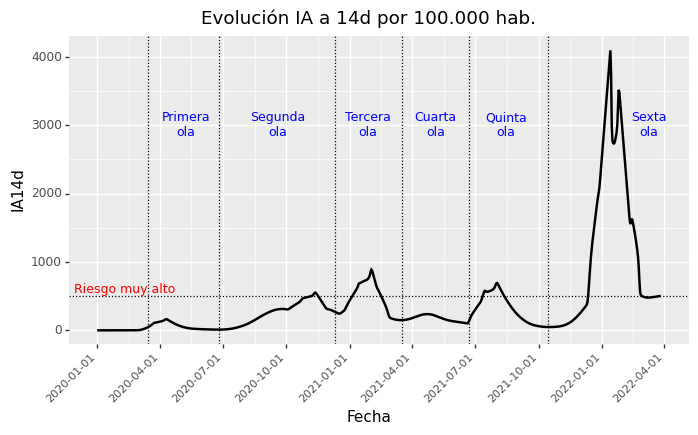

<ggplot: (8730658363933)>

In [34]:
(
    ggplot(casos_trend_pob)  
    + aes(x = 'fecha', 
          y = 'ia14d')   
    #+ geom_rect(data=df, mapping=aes(xmin=df.x1, xmax=df.x2, ymin=0, ymax=80000, fill=df.r), color="black", alpha=0.5)
    + geom_smooth(method = "lowess", 
                  span = 0.05)

    #+ geom_hline(yintercept = 500, size = 0.5, linetype = 'dotted')
    + geom_hline(yintercept = 500, size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2020-03-15', size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2020-06-25', size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2020-12-10', size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2021-03-17', size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2021-06-23', size = 0.5, linetype = 'dotted')
    + geom_vline(xintercept = '2021-10-14', size = 0.5, linetype = 'dotted')
    + theme(figure_size=(8, 4),
            axis_text_x = element_text(angle = 45,
                                      hjust = 1,
                                      size = 8))
    + annotate('text', x='2020-02-10', y=600, label='Riesgo muy alto', size=9, color='red')
    + annotate('text', x='2020-05-08', y=3000, label='Primera\nola', size=9, color='blue')
    + annotate('text', x='2020-09-18', y=3000, label='Segunda\nola', size=9, color='blue')
    + annotate('text', x='2021-01-27', y=3000, label='Tercera\nola', size=9, color='blue')
    + annotate('text', x='2021-05-05', y=3000, label='Cuarta\nola', size=9, color='blue')
    + annotate('text', x='2021-08-15', y=3000, label='Quinta\nola', size=9, color='blue')
    + annotate('text', x='2022-03-10', y=3000, label='Sexta\nola', size=9, color='blue')
    + labs(title='Evolución IA a 14d por 100.000 hab.', x='Fecha', y='IA14d')
)


Se visualizan picos en determinados momentos de la pandemia, que corresponden a las diferentes olas, notándose especialmente la correspondiente a la sexta ola de la pandemia.

## Población de cada franja etaria para cada provincia

**Si anteriormente habíamos hecho el groupby de preparación de datos por fecha y periodo, ahora lo haremos por periodo y franja_etaria. Esto se debe a que queremos visualizar**

In [35]:
cov_prv.head()

,provincia_iso,sexo,franja_etaria,fecha,num_casos,num_hosp,num_uci,num_def,code,postal_code,periodo,semana
0,A,H,0-9,2020-01-01,0,0,0,0,A,3.0,2020,1
1,A,H,10-19,2020-01-01,0,0,0,0,A,3.0,2020,1
2,A,H,20-29,2020-01-01,0,0,0,0,A,3.0,2020,1
3,A,H,30-39,2020-01-01,0,0,0,0,A,3.0,2020,1
4,A,H,40-49,2020-01-01,0,0,0,0,A,3.0,2020,1


In [36]:
cov_prv.describe(include = 'all')

,provincia_iso,sexo,franja_etaria,fecha,num_casos,num_hosp,num_uci,num_def,code,postal_code,periodo,semana
count,1274520,1299030,1299030,1299030,1.299030e+06,1.299030e+06,1.299030e+06,1.299030e+06,1250010,1.274520e+06,1.299030e+06,1.299030e+06
unique,52,3,10,817,NaN,NaN,NaN,NaN,51,NaN,NaN,NaN
top,A,H,0-9,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN
freq,24510,433010,129903,1590,NaN,NaN,NaN,NaN,24510,NaN,NaN,NaN
first,NaN,NaN,NaN,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2022-03-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,8.916302e+00,4.002325e-01,3.814539e-02,7.993349e-02,NaN,2.650000e+01,2.020657e+03,2.473317e+01
std,NaN,NaN,NaN,NaN,5.078917e+01,2.523791e+00,3.111515e-01,8.045517e-01,NaN,1.500834e+01,6.601430e-01,1.563225e+01
min,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,1.000000e+00,2.020000e+03,1.000000e+00
25%,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,1.375000e+01,2.020000e+03,1.000000e+01


In [37]:
casos_franja_periodo = cov_prv.groupby(['periodo',
                                        'franja_etaria',
                                        'provincia_iso']).agg({'num_casos':'sum',
                                                               'num_hosp':'sum', 
                                                               'num_uci':'sum', 
                                                               'num_def':'sum'}).reset_index()

In [38]:
casos_franja_periodo.head()

,periodo,franja_etaria,provincia_iso,num_casos,num_hosp,num_uci,num_def
0,2020,0-9,A,3620,46,2,0
1,2020,0-9,AB,929,20,4,1
2,2020,0-9,AL,1815,21,2,0
3,2020,0-9,AV,369,3,0,0
4,2020,0-9,B,15477,77,1,0


In [40]:
casos_franja_periodo.tail(20)

,periodo,franja_etaria,provincia_iso,num_casos,num_hosp,num_uci,num_def
1540,2022,NC,O,42,0,0,0
1541,2022,NC,OR,0,0,0,0
1542,2022,NC,P,1,0,0,0
1543,2022,NC,PM,0,0,0,0
1544,2022,NC,PO,0,0,0,0
1545,2022,NC,S,0,0,0,0
1546,2022,NC,SA,8,1,0,0
1547,2022,NC,SE,5,0,0,0
1548,2022,NC,SG,3,0,0,0
1549,2022,NC,SO,3,0,0,0


**Hacemos un merge para incorporar a nuestros datos de covid, ya agrupados, los datos de población por provincia y periodo**

In [41]:
poblacion.head()

,periodo,provincia,postal_code,franja_etaria,total,code,name,phone_code,iso2
0,2020,01 Araba/Álava,1,0-9,31709.299340,VI,Álava,945,ES
1,2020,01 Araba/Álava,1,10-19,32961.976182,VI,Álava,945,ES
2,2020,01 Araba/Álava,1,20-29,29243.296939,VI,Álava,945,ES
3,2020,01 Araba/Álava,1,30-39,38658.627289,VI,Álava,945,ES
4,2020,01 Araba/Álava,1,40-49,54453.120853,VI,Álava,945,ES


In [42]:
poblacion.describe(include = 'all')

,periodo,provincia,postal_code,franja_etaria,total,code,name,phone_code,iso2
count,1404.000000,1404,1404.000000,1404,1.404000e+03,1377,1404,1404.000000,1404
unique,NaN,52,NaN,9,NaN,51,52,NaN,1
top,NaN,01 Araba/Álava,NaN,0-9,NaN,VI,Álava,NaN,ES
freq,NaN,27,NaN,156,NaN,27,27,NaN,1404
mean,2021.000000,NaN,26.500000,NaN,1.013547e+05,NaN,NaN,823.673077,NaN
std,0.816788,NaN,15.013679,NaN,1.406404e+05,NaN,NaN,311.614341,NaN
min,2020.000000,NaN,1.000000,NaN,2.460064e+03,NaN,NaN,91.000000,NaN
25%,2020.000000,NaN,13.750000,NaN,3.103409e+04,NaN,NaN,924.000000,NaN
50%,2021.000000,NaN,26.500000,NaN,6.179577e+04,NaN,NaN,951.500000,NaN
75%,2022.000000,NaN,39.250000,NaN,1.093192e+05,NaN,NaN,973.250000,NaN


In [43]:
casos_franja_periodo = casos_franja_periodo.merge(poblacion,
                                                  how='left', 
                                                  left_on=['periodo', 
                                                           'franja_etaria',
                                                           'provincia_iso'],
                                                  right_on=['periodo', 
                                                           'franja_etaria',
                                                           'code'])

In [44]:
casos_franja_periodo.rename(columns={'total':'poblacion'}, inplace=True)

In [45]:
casos_franja_periodo.head()

,periodo,franja_etaria,provincia_iso,num_casos,num_hosp,num_uci,num_def,provincia,postal_code,poblacion,code,name,phone_code,iso2
0,2020,0-9,A,3620,46,2,0,03 Alicante/Alacant,3.0,168506.146511,A,Alacant,950.0,ES
1,2020,0-9,AB,929,20,4,1,02 Albacete,2.0,34689.677644,AB,Albacete,967.0,ES
2,2020,0-9,AL,1815,21,2,0,04 Almería,4.0,79321.627465,AL,Almería,920.0,ES
3,2020,0-9,AV,369,3,0,0,05 Ávila,5.0,11841.897665,AV,Ávila,924.0,ES
4,2020,0-9,B,15477,77,1,0,08 Barcelona,8.0,532994.962320,B,Barcelona,93.0,ES


**Eliminamos NC y calculamos ratios de incidencia etc. por población para cada provincia y franja etaria**

In [46]:
casos_franja_periodo = casos_franja_periodo[casos_franja_periodo['franja_etaria']!='NC']
casos_franja_periodo['casos_x_cienmil'] = casos_franja_periodo['num_casos']/casos_franja_periodo['poblacion'] * 100000
casos_franja_periodo['hosp_x_cienmil'] = casos_franja_periodo['num_hosp']/casos_franja_periodo['poblacion'] * 100000
casos_franja_periodo['uci_x_cienmil'] = casos_franja_periodo['num_uci']/casos_franja_periodo['poblacion'] * 100000
casos_franja_periodo['def_x_cienmil'] = casos_franja_periodo['num_def']/casos_franja_periodo['poblacion'] * 100000

In [47]:
# Drop row that has all NaN values
casos_franja_periodo = casos_franja_periodo.dropna(how='all').reset_index(drop=True)



In [48]:
casos_franja_periodo['periodo'] = casos_franja_periodo['periodo'].astype({'periodo': 'str'})

In [49]:
casos_franja_periodo.describe(include = 'all')

,periodo,franja_etaria,provincia_iso,num_casos,num_hosp,num_uci,num_def,provincia,postal_code,poblacion,code,name,phone_code,iso2,casos_x_cienmil,hosp_x_cienmil,uci_x_cienmil,def_x_cienmil
count,1404,1404,1404,1404.000000,1404.000000,1404.000000,1404.000000,1377,1377.000000,1.377000e+03,1377,1377,1377.000000,1377,1377.000000,1377.000000,1377.000000,1377.000000
unique,3,9,52,NaN,NaN,NaN,NaN,51,NaN,NaN,51,51,NaN,1,NaN,NaN,NaN,NaN
top,2020,0-9,A,NaN,NaN,NaN,NaN,03 Alicante/Alacant,NaN,NaN,A,Alacant,NaN,ES,NaN,NaN,NaN,NaN
freq,468,156,27,NaN,NaN,NaN,NaN,27,NaN,NaN,27,27,NaN,1377,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,8078.304131,363.532764,34.597578,72.727920,NaN,26.411765,1.019072e+05,NaN,NaN,821.235294,NaN,8167.335751,427.733159,35.759500,115.451416
std,NaN,NaN,NaN,15041.925762,1023.386710,101.913725,320.987968,NaN,15.146895,1.419341e+05,NaN,NaN,314.164960,NaN,4878.264311,638.546049,54.011971,309.177197
min,NaN,NaN,NaN,89.000000,0.000000,0.000000,0.000000,NaN,1.000000,2.460064e+03,NaN,NaN,91.000000,NaN,806.317010,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,1898.500000,31.000000,2.000000,0.000000,NaN,13.000000,3.018179e+04,NaN,NaN,924.000000,NaN,4493.237784,60.811966,2.768955,0.000000
50%,NaN,NaN,NaN,3686.000000,113.500000,6.000000,4.000000,NaN,26.000000,6.110583e+04,NaN,NaN,953.000000,NaN,6584.607539,170.293304,13.118768,4.883419
75%,NaN,NaN,NaN,8040.750000,351.000000,30.000000,38.000000,NaN,40.000000,1.112141e+05,NaN,NaN,974.000000,NaN,11225.509569,532.157943,41.828961,61.181724


In [50]:
casos_franja_periodo.to_pickle("incidencia_acumulada_por_provincia.pkl")

## Heatmap (seaborn) de incidencia por provincia y por franja de edad

**Es importante señalar que ahora tenemos los datos ya proporcionales a población por**

**- franja etaria**
**- provincia**
**- año (2020, 21, 22)**

**y además para cada indicador: casos, hosp, uci, def**

**A continuación elegiremos un año**

In [51]:
casos_2020 = casos_franja_periodo.loc[(casos_franja_periodo['franja_etaria'] !='NC')
                                      & (casos_franja_periodo['periodo'] == '2020')]

**Y hacemos un pivot para preparar nuestros datos eligiendo únicamente el indicador de núm. (proporcional) de casos**

In [52]:
casos_2020_heatmap = casos_2020.pivot('name',
                                      'franja_etaria', 
                                      'casos_x_cienmil')


In [53]:
# Drop row that has all NaN values
casos_2020_heatmap = casos_2020_heatmap.dropna(how='all')



In [54]:
casos_2020_heatmap.head()

franja_etaria,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
name,,,,,,,,,
A Coruña,1702.041046,2041.408395,3131.178582,2730.228444,2323.631272,2296.231486,2101.924426,1997.415470,2585.273511
Alacant,2148.289588,3043.569583,3991.890795,3351.654351,3107.301481,3022.367099,2568.335215,2434.566861,3342.837843
Albacete,2678.030074,3901.835923,4560.948663,4367.818273,4444.607647,4650.208707,4415.713799,4128.302738,6344.177483
Almería,2288.152750,3251.075487,4227.022953,3630.468219,3167.376899,2813.084529,2266.911472,1808.564952,2587.084343
Asturias,1641.795962,2625.177955,3177.053581,2686.381896,2626.677790,2654.670306,2247.670200,2224.969551,4666.055831


Text(157.72222222222223, 0.5, 'Provincias')

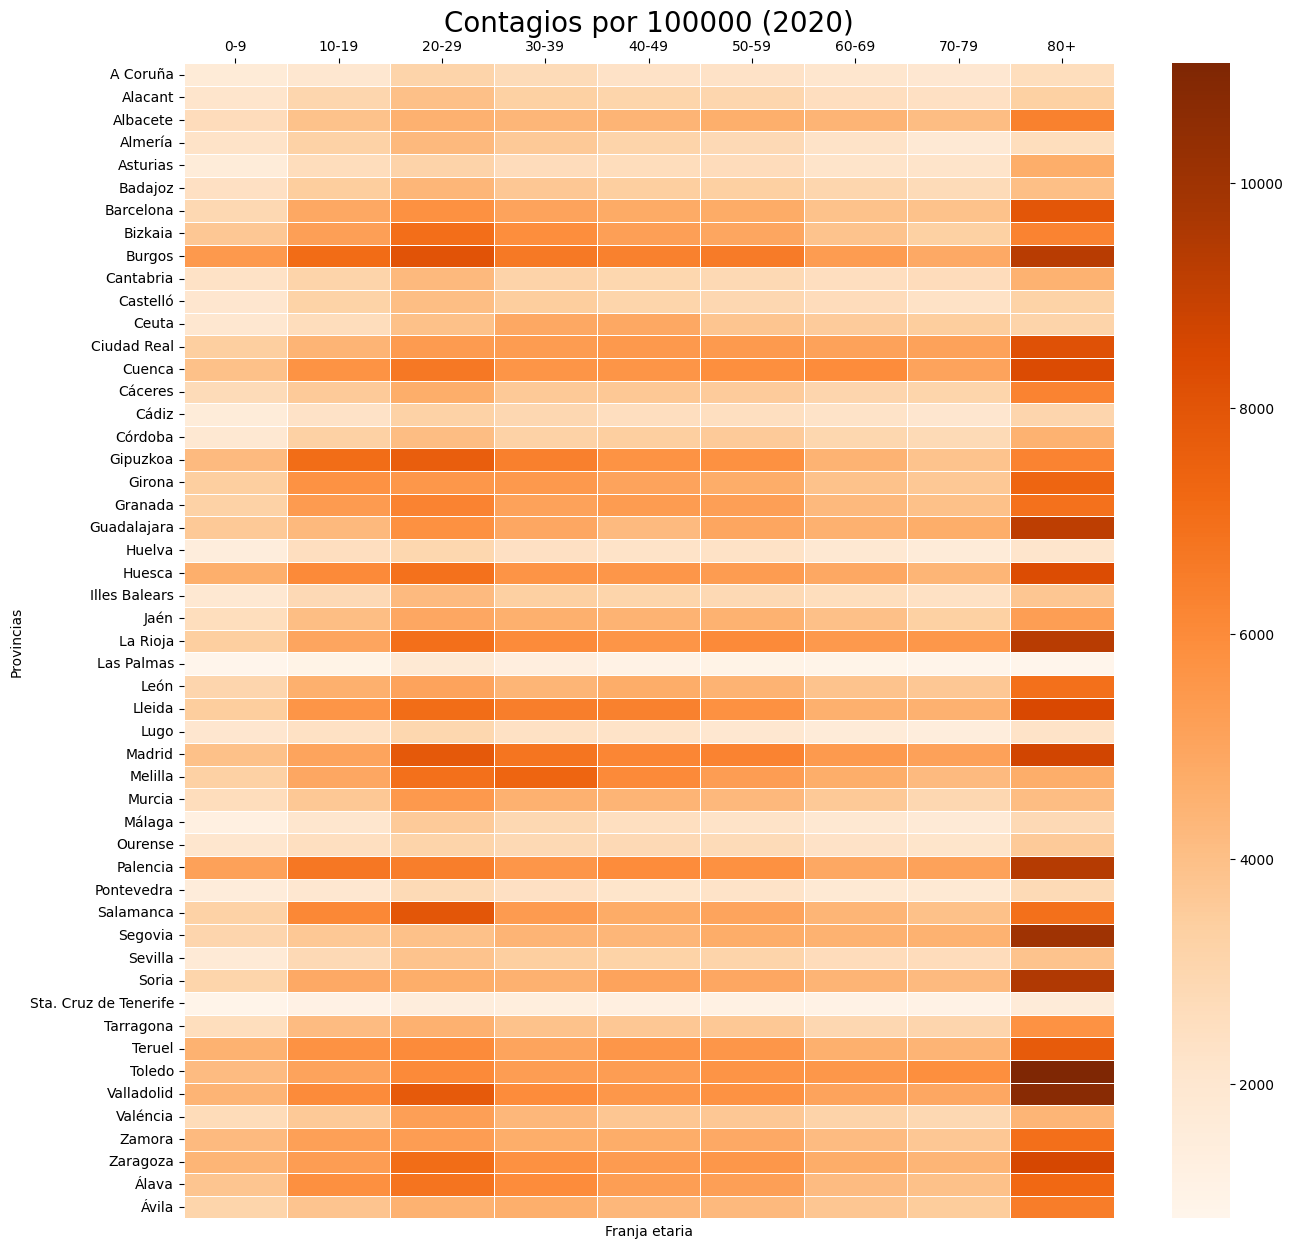

In [55]:
fig, ax = plt.subplots(figsize=(15,15))        
#mypalette = sns.color_palette("YlOrBr", as_cmap=True)
ax = sns.heatmap(casos_2020_heatmap
                , cmap = 'Oranges'
                #, annot=True
                , linewidth=.5
                )
ax.xaxis.tick_top()
ax.set_title('Contagios por 100000 (2020)', fontsize =20)
plt.xlabel('Franja etaria') 
plt.ylabel('Provincias') 



**Veamos las diferencias por UCI**

In [56]:
uci_2020_heatmap = casos_2020.pivot('name',
                                      'franja_etaria', 
                                      'uci_x_cienmil')

In [57]:
# Drop row that has all NaN values
uci_2020_heatmap = uci_2020_heatmap.dropna(how='all')


Text(157.72222222222223, 0.5, 'Provincias')

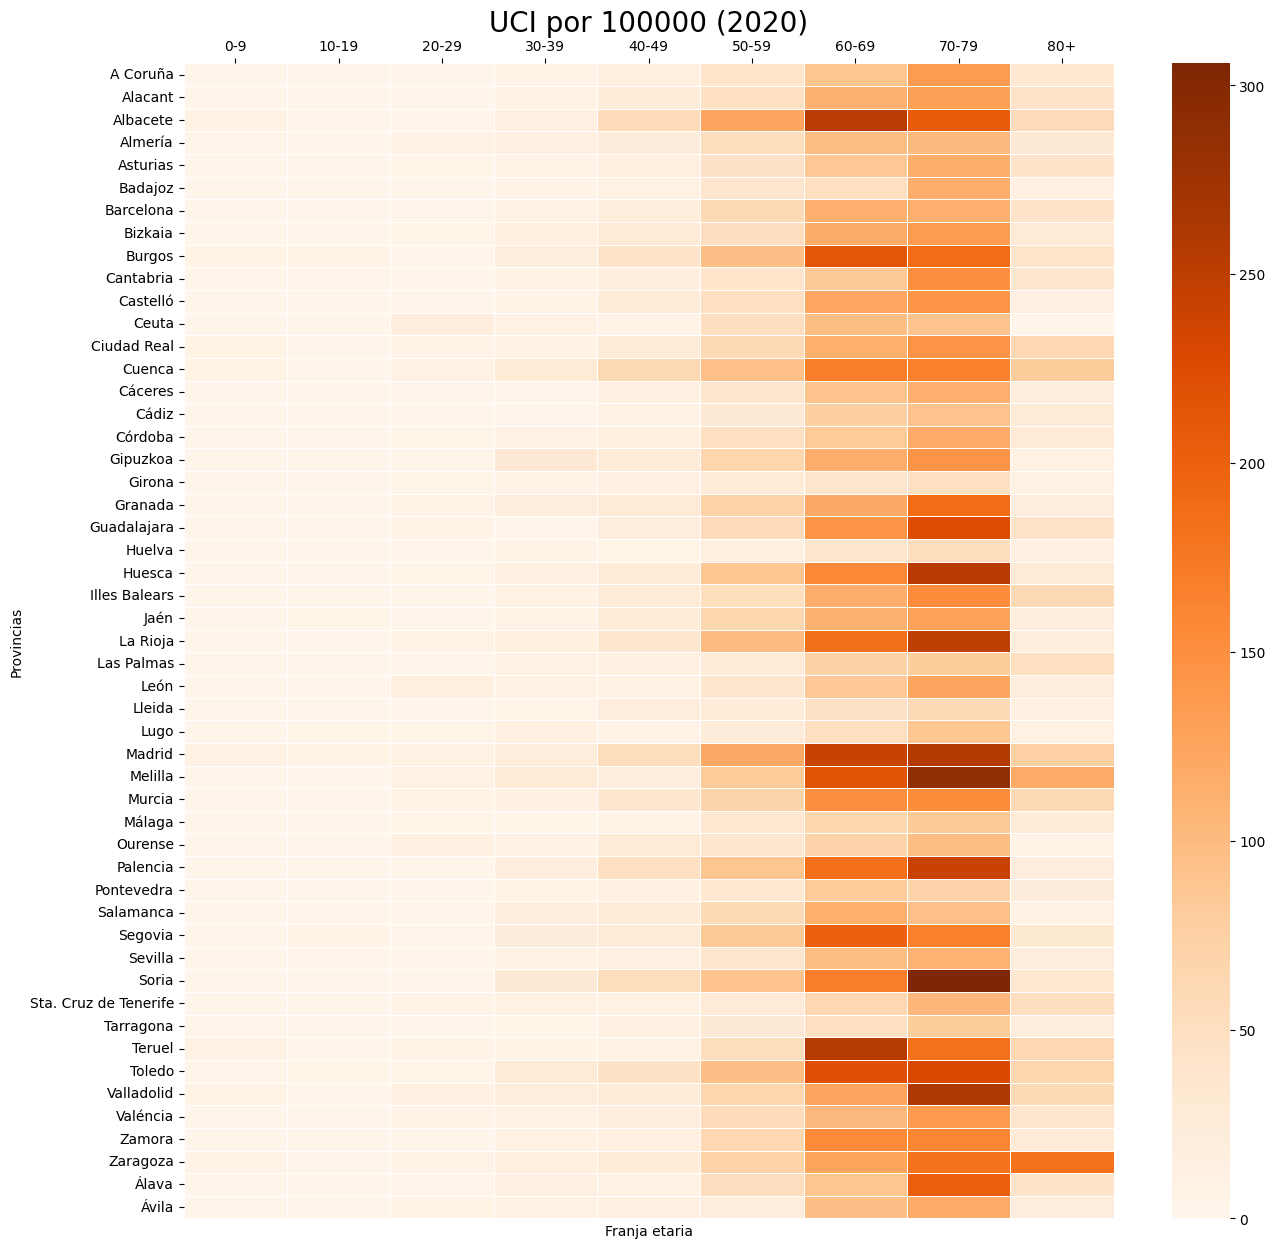

In [58]:
fig, ax = plt.subplots(figsize=(15,15))        
#mypalette = sns.color_palette("YlOrBr", as_cmap=True)
ax2 = sns.heatmap(uci_2020_heatmap
                , cmap = 'Oranges'
                #, annot=True
                , linewidth=.5
                )
ax2.xaxis.tick_top()
ax2.set_title('UCI por 100000 (2020)', fontsize =20)
plt.xlabel('Franja etaria') 
plt.ylabel('Provincias') 

